# Imágenes Biomédicas. Tarea 2.
### Gaussian Matched Filters

**Diego Moreno**

En este reporte se habla acerca de los resultados obtenidos para la detección de bordes usando como base las ideas de los filtros Gaussianos. En este método se generan filtros de tamaño T=13, con varianza para la función Gaussiana de 2 y los filtros son rotados con una resolución de 15 grados para detectar las arteriar en cierta dirección. Con cada filtro, se realiza una centralización de los mismo para posteriormente hacer convoluciones en la imagen a detectar los bordes; quedandose así, con el filtro que tenga un mayor valor en la convolución. De esta manera, se pondrá el mayor valor en el píxel central de la convolución. Como resultado se espera una imagen con los bordes o arteriar resaltadas.

En la primera parte, se usan las imágenes de la base de datos de http://personal.cimat.mx:8181/~ivan.cruz/Databases.html, y en la segunda parte la base de datos de la retina. Para los datos de la retina, se convierte cada imagen a escala de grises para así lograr detectar los bordes al trabajar con ellas.

Al final del reporte se habla respecto a las conclusiones.

Importamos las librerías:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
from matplotlib import transforms

Filtro Gaussiano:

In [2]:
def GMF(T=13, sg=2, k=255, angle=0):
    '''
    Función que crea un filtro gaussiano de tamaño TxT
    '''
    # Filtro Gaussiano
    x = np.array([-(T//2)+i for i in range(T)])
    tmp = np.exp(-(x**2) / (2*sg**2))
    fil = [-tmp*k for i in range(T)]
    
    # Rotación
    rot = np.array([[np.cos(angle), -np.sin(angle)], [np.sin(angle), np.cos(angle)]])
    fil_rot = np.zeros((T,T))
    for i in range(T):
        for j in range(T):
            idx = rot@[j-(T//2),i-(T//2)]
            X = int(idx[1] + T//2 +.5)
            Y = int(idx[0] + T//2 +.5)
            
            if X<T and X>=0 and Y<T and Y>=0:
                fil_rot[Y][X] = fil[j][i]
    # Relleno
    for i in range(T):
        for j in range(T):
            if fil_rot[i][j] == 0:
                suma = 0
                size = 0
                if i-1>0:
                    suma += fil_rot[i-1][j]
                    size += 1
                if j-1>0:
                    suma += fil_rot[i][j-1]
                    size += 1
                if i+1<T:
                    suma += fil_rot[i+1][j]
                    size += 1
                if j+1<T:
                    suma += fil_rot[i][j+1]
                    size += 1
                suma /= size
                fil_rot[i][j] = suma
    # Media del kernel
    m = sum(sum(fil_rot))/T**2
    # Filtro Gaussiano centrado
    fil_rot_m = fil_rot - m
    
    return fil_rot_m

Mostramos los **12 filtros** que usaremos con resolución de **15 grados**:

In [48]:
ang = np.pi/12

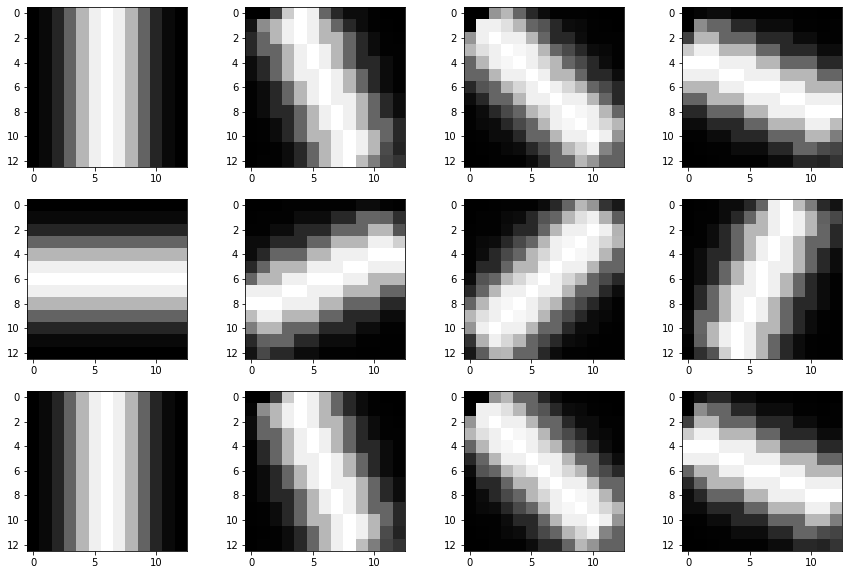

In [53]:
plt.figure(figsize=(15,10))
count = 0
for i in range(3):
    for j in range(4):
        plt.subplot2grid((3,4),(i,j))
        plt.imshow(GMF(13,2,255,ang*count), 'Greys')
        count += 1
plt.show()

# Algoritmo GMF para los angiogramas:

Probamos primero para la base de datos anterior, recordando que lo que haremos es una convolución con estos filtros y quedarnos con el mayor. Será un ejemplo de una imagen para posteriormente realizar mediciones cuantitativas de toda la base de datos.

Leemos la base de datos:

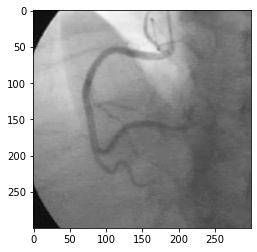

In [5]:
def readpgm(name):
    '''
    Función para leer imágenes en formato PGM
    '''
    with open(name) as f:
        lines = f.readlines()
    # This ignores commented lines
    for l in list(lines):
        if l[0] == '#':
            lines.remove(l)
    # here,it makes sure it is ASCII format (P2)
    assert lines[0].strip() == 'P2' 
    # Converts data to a list of integers
    data = []
    for line in lines[1:]:
        data.extend([int(c) for c in line.split()])
    return (np.array(data[3:]),(data[1],data[0]),data[2])

pth = 'Database_134_Angiograms/'
data = readpgm(pth + '1.pgm')
img = np.reshape(data[0],data[1])
plt.imshow(img, 'binary_r')
plt.show()

Función del algoritmo de convolución:

In [6]:
def padding(img, n=3):
    '''
    Función que le hace un padding a una imagen de tamaño n
    '''
    h = len(img)
    w = len(img[0])
    new_img = [[0 for i in range(w+2*n)] for i in range(h+2*n)]
    for i in range(h):
        for j in range(w):
            new_img[n+i][n+j] = img[i,j]
    return np.array(new_img)

def convolve(kernel=[], img=[], center=[]):
    '''
    Función que hace una convolución simple de un kernel dado
    en el centro dado de una imagen.
    '''
    b = len(kernel)//2
    suma = sum(sum(kernel*img[(center[0]-b):(center[0]+b+1), (center[1]-b):(center[1]+b+1)]))
    return suma

def match_filters(img, T=13, sigma=2, num_filters=12):
    '''
    Función que genera 12 tipos de filtros Gaussianos y con cada uno
    realiza una convolución a una imagen, donde para un píxel se queda
    con el valor mayor de cada filtro.
    
    '''
    #Hacemos un padding para hacer posteriormente la convolución
    b = T//2
    img_pad = padding(img, b)
    
    #Generamos los filtros Gaussianos
    kernel = []
    angle = np.pi/num_filters
    for k in range(num_filters):
        kernel.append(GMF(T, sigma, 1, angle*k))
    
    #Algoritmo
    new_img = np.zeros(img.shape)
    for i in range(len(img)):
        for j in range(len(img[0])):
            center = [b+i, b+j]
            max_val = 0
            # Encontrar el mejor GMF
            for k in range(num_filters):
                conv = convolve(kernel[k], img_pad, center)
                if conv > max_val:
                    max_val = conv
            # Nos quedamos con el valor mayor
            new_img[i][j] = max_val
            
    return new_img

Mostramos un ejemplo del resultado con GMF

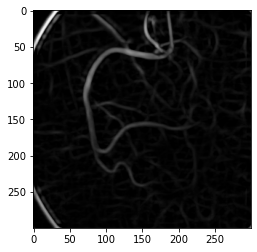

In [7]:
T = 13
sigma = 2
filters = 12

img_matched = match_filters(img, T, sigma, filters)
plt.imshow(img_matched, 'Greys_r')
plt.show()

Ahora, binarizamos la imagen para tener blanco y negro: 

In [29]:
def black_white(img):
    '''
    Función que binariza a blanco y negro una imagen en escala de grises.
    '''
    img_bw = np.zeros(img.shape)
    idx = img > 255/2
    img_bw[idx] = 255
    
    return img_bw

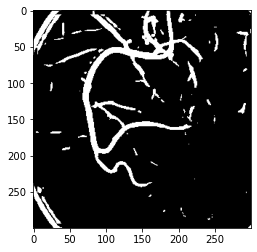

In [31]:
img_matched_bw = black_white(img_matched)
plt.imshow(img_matched_bw, 'binary_r')
plt.show()

El cual tiene un excelente resultado al compararlo con el ground truth:

Imagen generada con GMF.				Imagen del Ground Truth


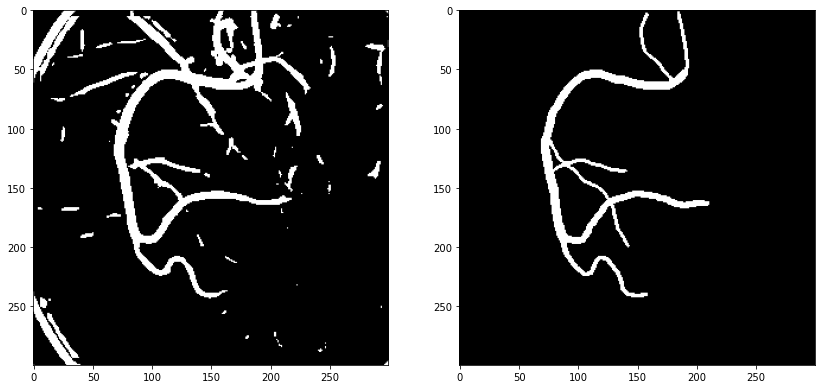

In [32]:
data = readpgm(pth + '1_gt.pgm')
img_gt = np.reshape(data[0],data[1])
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched_bw, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

Lo evaluamos de manera cuantitativa:

In [33]:
def metrics(img, img_gt):
    '''
    Función que regresa las siguientes cantidades de una imagen:
        True Positives  : tp 
        True Negatives  : tn
        False Positives : fp
        False Negatives : fn
    ordenados en una lista de la forma [tp, tn, fp, fn]
    '''
    tp = 0
    tn = 0
    fp = 0
    fn = 0
    for i in range(len(img)):
        for j in range(len(img[0])):
            if img_gt[i][j]==255 and img[i][j]==255:
                tp += 1
            elif img_gt[i][j]==0 and img[i][j]==0:
                tn += 1
            elif img_gt[i][j]==0 and img[i][j]==255:
                fp += 1
            elif img_gt[i][j]==255 and img[i][j]==0:
                fn += 1
    return [tp, tn, fp, fn]

def sensitivity(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn)

def specificity(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fp)

def accuracy(tp=0, tn=0, fp=0, fn=0):
    return (tp+tn)/(tp+tn+fp+fn)

def pos_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fp)

def neg_pred_val(tp=0, tn=0, fp=0, fn=0):
    return tn/(tn+fn)

def matthews_cc(tp=0, tn=0, fp=0, fn=0):
    return ((tp*tn) - (fp*fn))/((tp+fp)*(tp+fn)*(tn+fp)*(tn+fn))**(1/2)

def jaccard(tp=0, tn=0, fp=0, fn=0):
    return tp/(tp+fn+fp)

def dice(tp=0, tn=0, fp=0, fn=0):
    return 2*tp/(2*tp+fn+fp)

In [35]:
angio_metrics = metrics(img_matched_bw, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]))

Métricas para la imagen generada por GMF:
Sensitivity: 				0.908
Specificity: 				0.935
Accuracy: 				0.934
Positive Predictive Value: 		0.379
Negative Predictive Value: 		0.996
Matthews Correlation Coefficient: 	0.562
Jaccard Index: 				0.365
Dice Coefficient: 			0.535


Se obtiene un gran desempeño con un accuracy de 0.81.

Ahora, leemos todas las imágenes de la base de datos y reportaremos el promedio de las métricas totales de la base de datos.

In [36]:
#En total son 134 imágenes a leer
imgs = []
imgs_gt = []
for i in range(134):
    data = readpgm(pth + str(i+1) + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs.append(img_aux)
    data = readpgm(pth + str(i+1) + '_gt' + '.pgm')
    img_aux = np.reshape(data[0],data[1])
    imgs_gt.append(img_aux)

In [47]:
T = 13
sigma = 2
filters = 12
angio_metrics_tot = []

for i in range(134):
    img_ls = match_filters(imgs[i], T, sigma, filters)
    img_ls = black_white(img_ls)
    #Metricas
    angio_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   specificity(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   accuracy(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   pos_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   neg_pred_val(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   matthews_cc(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   jaccard(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3]),
                   dice(angio_metrics[0],angio_metrics[1],angio_metrics[2],angio_metrics[3])]
    angio_metrics_tot.append(metrics_aux)

KeyboardInterrupt: 

In [ ]:
angio_metrics_tot_mean = np.mean(angio_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de GMF:')
print('Sensitivity: \t\t\t\t%.3f' % angio_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % angio_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % angio_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % angio_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % angio_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % angio_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % angio_metrics_tot_mean[7])

Notamos que para la base de datos de los angiogramas, logra un muy buen desempeño logrando un accuracy promdeio de 0.74 en todas las imágenes de ground truth.

Siguiente paso es probar que tan bien funciona el algoritmo con la base de datos de la retina.

# GMF en datos de Retina

Hacemos una prueba para una imagen dada de ejemplo:

In [ ]:
pth = 'DRIVE_retina/training/images/'
img = plt.imread(pth + '21_training.tif')
plt.imshow(img, 'Greys_r')
plt.show()

Para trabajar, necesitamos convertir la imagen a escala de grises:

In [ ]:
ra = np.array(img[:, :, 0])
ga = np.array(img[:, :, 1])
ba = np.array(img[:, :, 2])

img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
plt.imshow(img_gray, 'Greys_r')
plt.show()

Mostramos un ejemplo de GMF:

In [ ]:
T = 13
sigma = 2
filters = 12

img_matched = match_filters(img_gray, T, sigma, filters)
plt.imshow(img_matched, 'Greys_r')
plt.show()

LA binarizamos a solamente blanco y negro:

In [ ]:
img_matched_bw = black_white(img_matched)
plt.imshow(img_matched_bw, 'binary_r')
plt.show()

Comparamos con el ground truth:

In [ ]:
pth = 'DRIVE_retina/training/1st_manual/'
img_gt = plt.imread(pth + '21_manual1.gif')
print('Imagen generada con GMF.\t\t\t\tImagen del Ground Truth')
plt.figure(figsize=(14,20))
plt.subplot(121)
plt.imshow(img_matched_bw, 'binary_r')
plt.subplot(122)
plt.imshow(img_gt, 'binary_r')
plt.show()

Resultado cuantitativo:

In [ ]:
retina_metrics = metrics(img_matched_bw, img_gt)
print('Métricas para la imagen generada por GMF:')
print('Sensitivity: \t\t\t\t%.3f' % sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Specificity: \t\t\t\t%.3f' % specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Accuracy: \t\t\t\t%.3f' % accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Positive Predictive Value: \t\t%.3f' % pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Negative Predictive Value: \t\t%.3f' % neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Matthews Correlation Coefficient: \t%.3f' % matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Jaccard Index: \t\t\t\t%.3f' % jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))
print('Dice Coefficient: \t\t\t%.3f' % dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]))

El cual es un resultado similarmente bueno que con los angiogramas, logrando un accuracy de 0.75 en la imagen de prueba.

Finalmente, realizamos la deteccion de bordes con GMF para toda la base de datos de la retina (incluyendo training y test) para después reportar el valor promedio de las metricas obtenidas en cada imagen.

In [ ]:
#Imágenes a leer
imgs = []
imgs_gt = []
pth = 'DRIVE_retina/training/'
for i in range(20):
    img_aux = plt.imread(pth + 'images/' + str(i+21) + '_training.tif')
    imgs.append(img_aux)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+21) + '_manual1.gif')
    imgs_gt.append(img_aux)
pth = 'DRIVE_retina/test/'
for i in range(9):
    img_aux = plt.imread(pth + 'images/0' + str(i+1) + ' test.tif')
    imgs.append(img_aux)
    img_aux = plt.imread(pth + '1st_manual/0' + str(i+1) + '_manual1.gif')
    imgs_gt.append(img_aux)
for i in range(11):
    img_aux = plt.imread(pth + 'images/' + str(i+10) + ' test.tif')
    imgs.append(img_aux)
    img_aux = plt.imread(pth + '1st_manual/' + str(i+10) + '_manual1.gif')
    imgs_gt.append(img_aux)

In [ ]:
T = 13
sigma = 2
filters = 12
retina_metrics_tot = []

for i in range(len(imgs)):
    ra = np.array(imgs[i][:, :, 0])
    ga = np.array(imgs[i][:, :, 1])
    ba = np.array(imgs[i][:, :, 2])

    img_gray = (0.299*ra + 0.587*ga + 0.114*ba)
    img_ls = match_filters(img_gray, T, sigma, filters)
    img_ls = black_white(img_ls)
    #Metricas
    retina_metrics = metrics(img_ls, imgs_gt[i])
    metrics_aux = [sensitivity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   specificity(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   accuracy(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   pos_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   neg_pred_val(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   matthews_cc(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   jaccard(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3]),
                   dice(retina_metrics[0],retina_metrics[1],retina_metrics[2],retina_metrics[3])]
    retina_metrics_tot.append(metrics_aux)

In [ ]:
retina_metrics_tot_mean = np.mean(retina_metrics_tot, axis=0)
print('Promedios de las métricas:\n\n')
print('Métricas del algoritmo de GMF:')
print('Sensitivity: \t\t\t\t%.3f' % retina_metrics_tot_mean[0])
print('Specificity: \t\t\t\t%.3f' % retina_metrics_tot_mean[1])
print('Accuracy: \t\t\t\t%.3f' % retina_metrics_tot_mean[2])
print('Positive Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[3])
print('Negative Predictive Value: \t\t%.3f' % retina_metrics_tot_mean[4])
print('Matthews Correlation Coefficient: \t%.3f' % retina_metrics_tot_mean[5])
print('Jaccard Index: \t\t\t\t%.3f' % retina_metrics_tot_mean[6])
print('Dice Coefficient: \t\t\t%.3f' % retina_metrics_tot_mean[7])

El cual, logra subir el accuracy a 0.76.

Como conclusión de este reporte se logra notar que el método de los filtros Gaussianos es una excelente idea pues al tener cada filtro la forma de arteria y al rotar cada filtro, se logra captar de manera eficiente a la arteria y cualquier otro borde parecido a él. Se obtienen resultados satisfactorios, pues a pesar de que para la retina se obtiene un accuracy de .76, esto es casi seguramente debido a que se detecta el borde ocular y en las imagenes del ground truth no existe. Además, notamos que en la retina hay arterias más delgadas por lo que se optó por jugar con varios tamaños de filtro, ganando aún así el de tamño 13. Una propuesta a futuro es: así como se variaba el ángulo de rotación del filtro, también se debe variar los varios tamaños del filtro y quedarse con el de mayor convolución, pues así se detectará mejor arterias delgadas y gruesas.

In [46]:
poblacion = []
for _ in range(3):
    fam = []
    for i in range(2):
        im = np.array([np.round(np.random.random_sample(4)*10) for _ in range(4)])
        fam.append(im)
        print (im)
    poblacion.append(np.array(fam))
    
birth = (poblacion[-1] + poblacion[-2])/2
poblacion[0] = birth
print(poblacion)

[[7. 4. 4. 9.]
 [0. 8. 1. 8.]
 [2. 4. 6. 1.]
 [7. 9. 5. 2.]]
[[ 5.  1.  7.  4.]
 [ 8.  8.  4.  4.]
 [ 9.  9.  1. 10.]
 [ 1.  2.  7.  5.]]
[[9. 9. 3. 6.]
 [9. 7. 4. 4.]
 [4. 2. 6. 4.]
 [3. 1. 8. 4.]]
[[ 3.  4.  8.  2.]
 [ 7.  3.  2.  6.]
 [10.  1.  3.  1.]
 [ 9.  5.  9.  9.]]
[[1. 4. 1. 9.]
 [2. 0. 4. 4.]
 [6. 6. 4. 6.]
 [1. 1. 7. 8.]]
[[5. 1. 6. 3.]
 [9. 0. 1. 1.]
 [7. 8. 3. 3.]
 [2. 3. 2. 0.]]
[array([[[5. , 6.5, 2. , 7.5],
        [5.5, 3.5, 4. , 4. ],
        [5. , 4. , 5. , 5. ],
        [2. , 1. , 7.5, 6. ]],

       [[4. , 2.5, 7. , 2.5],
        [8. , 1.5, 1.5, 3.5],
        [8.5, 4.5, 3. , 2. ],
        [5.5, 4. , 5.5, 4.5]]]), array([[[ 9.,  9.,  3.,  6.],
        [ 9.,  7.,  4.,  4.],
        [ 4.,  2.,  6.,  4.],
        [ 3.,  1.,  8.,  4.]],

       [[ 3.,  4.,  8.,  2.],
        [ 7.,  3.,  2.,  6.],
        [10.,  1.,  3.,  1.],
        [ 9.,  5.,  9.,  9.]]]), array([[[1., 4., 1., 9.],
        [2., 0., 4., 4.],
        [6., 6., 4., 6.],
        [1., 1., 7., 8.]],

     